<a href="https://colab.research.google.com/github/GurashishJuneja/MMAI831-Finance/blob/main/Assignment_2_MMAI_821_Question_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Question 2: For the companies we used in Q1, use monthly data fromn 2017-2021 to implement the following models:

a. One factor model (use S&P 500 to represent the market)

b. Fama-French 3 factor models.

c. Use the resulting models to calculate the predicted monthly returns for each month in 2022. You can use the factor values in 2022 (S&P 500 index, and the F-F facgor values).

d. Compare them with the actual average monthly returns for the stocks. 



In [99]:
#For this question, I need to intialize the companies which have been used in the previous question

#Start with importing libraries

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install quandl
import quandl
import scipy.optimize as sco
import yfinance as yf
import pandas as pd

import statsmodels.api as sm
from scipy.optimize import minimize

np.random.seed(42)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Initial setup

In [100]:
# Define the stock symbols
stocks = ['AAPL', 'AMZN', 'GOOGL', 'BAC', 'MCD', 'CAT', 'TSLA', 'PFE']

# Create an empty DataFrame to store the data
data = pd.DataFrame()

# Loop through each stock symbol and retrieve the data
for stock in stocks:
    # Retrieve the daily stock data for the year 2022
    stock_data = yf.download(stock, start='2017-01-01', end='2022-12-31')
       
    # Add a column for the stock symbol
    stock_data.loc[:, 'ticker'] = stock
    
    # Append the stock data to the main DataFrame
    data = pd.concat([data, stock_data], axis=0)

# Reset the index of the DataFrame
data.reset_index(inplace=True)

# Select the desired columns
data = data[['Date', 'ticker', 'Adj Close']]

# Rename the columns to match the original code
data.columns = ['date', 'ticker', 'adj_close']

# Print the first few rows of the data
print(data.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
        date ticker  adj_close
0 2017-01-03   AAPL  27.095850
1 2017-01-04   AAPL  27.065523
2 2017-01-05   AAPL  27.203159
3 2017-01-06   AAPL  27.506428
4 2017-01-09   AAPL  27.758373


In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12080 entries, 0 to 12079
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       12080 non-null  datetime64[ns]
 1   ticker     12080 non-null  object        
 2   adj_close  12080 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 283.2+ KB


In [102]:
# Check if all the companies and time period are correctly selected  
print('The companies are:', data.ticker.unique(), 'and there is', len(data),'date entry points')
print('The date range of stock data is from', data.date.min(), ' to ',data.date.max())

The companies are: ['AAPL' 'AMZN' 'GOOGL' 'BAC' 'MCD' 'CAT' 'TSLA' 'PFE'] and there is 12080 date entry points
The date range of stock data is from 2017-01-03 00:00:00  to  2022-12-30 00:00:00


In [103]:
# keep this 'data' as original and use df. We drop the level(0), which is the adj_closed written on th first line, no need for it
df = data.set_index('date')
table = df.pivot(columns='ticker')
table.columns = table.columns.droplevel(0)
table.head()

ticker,AAPL,AMZN,BAC,CAT,GOOGL,MCD,PFE,TSLA
date,,,,,,,,
2017-01-03,27.095850,37.683498,19.599289,79.812828,40.400501,102.466896,24.618328,14.466000
2017-01-04,27.065523,37.859001,19.964655,79.456177,40.388500,102.346939,24.834679,15.132667
2017-01-05,27.203159,39.022499,19.729778,78.972168,40.651001,102.535400,25.073397,15.116667
2017-01-06,27.506428,39.799500,19.729778,79.006126,41.260502,103.443413,24.976414,15.267333
2017-01-09,27.758373,39.846001,19.616682,78.437202,41.359001,103.160713,24.968956,15.418667


Text(0, 0.5, 'price in $')

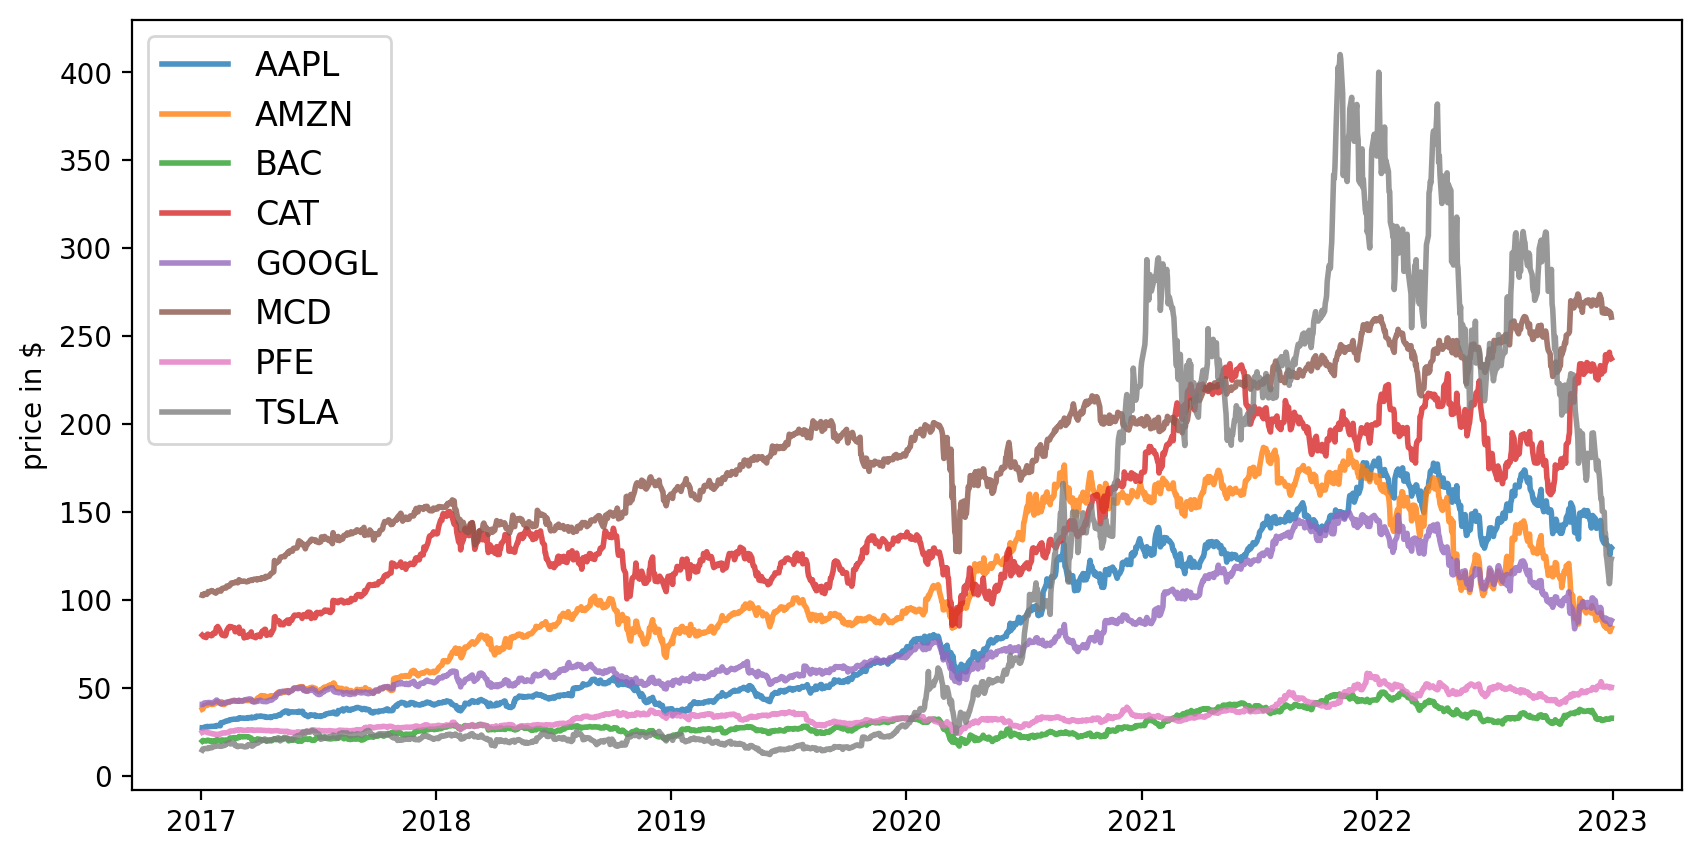

In [104]:

plt.figure(figsize=(10, 5))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=2, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, 'daily returns')

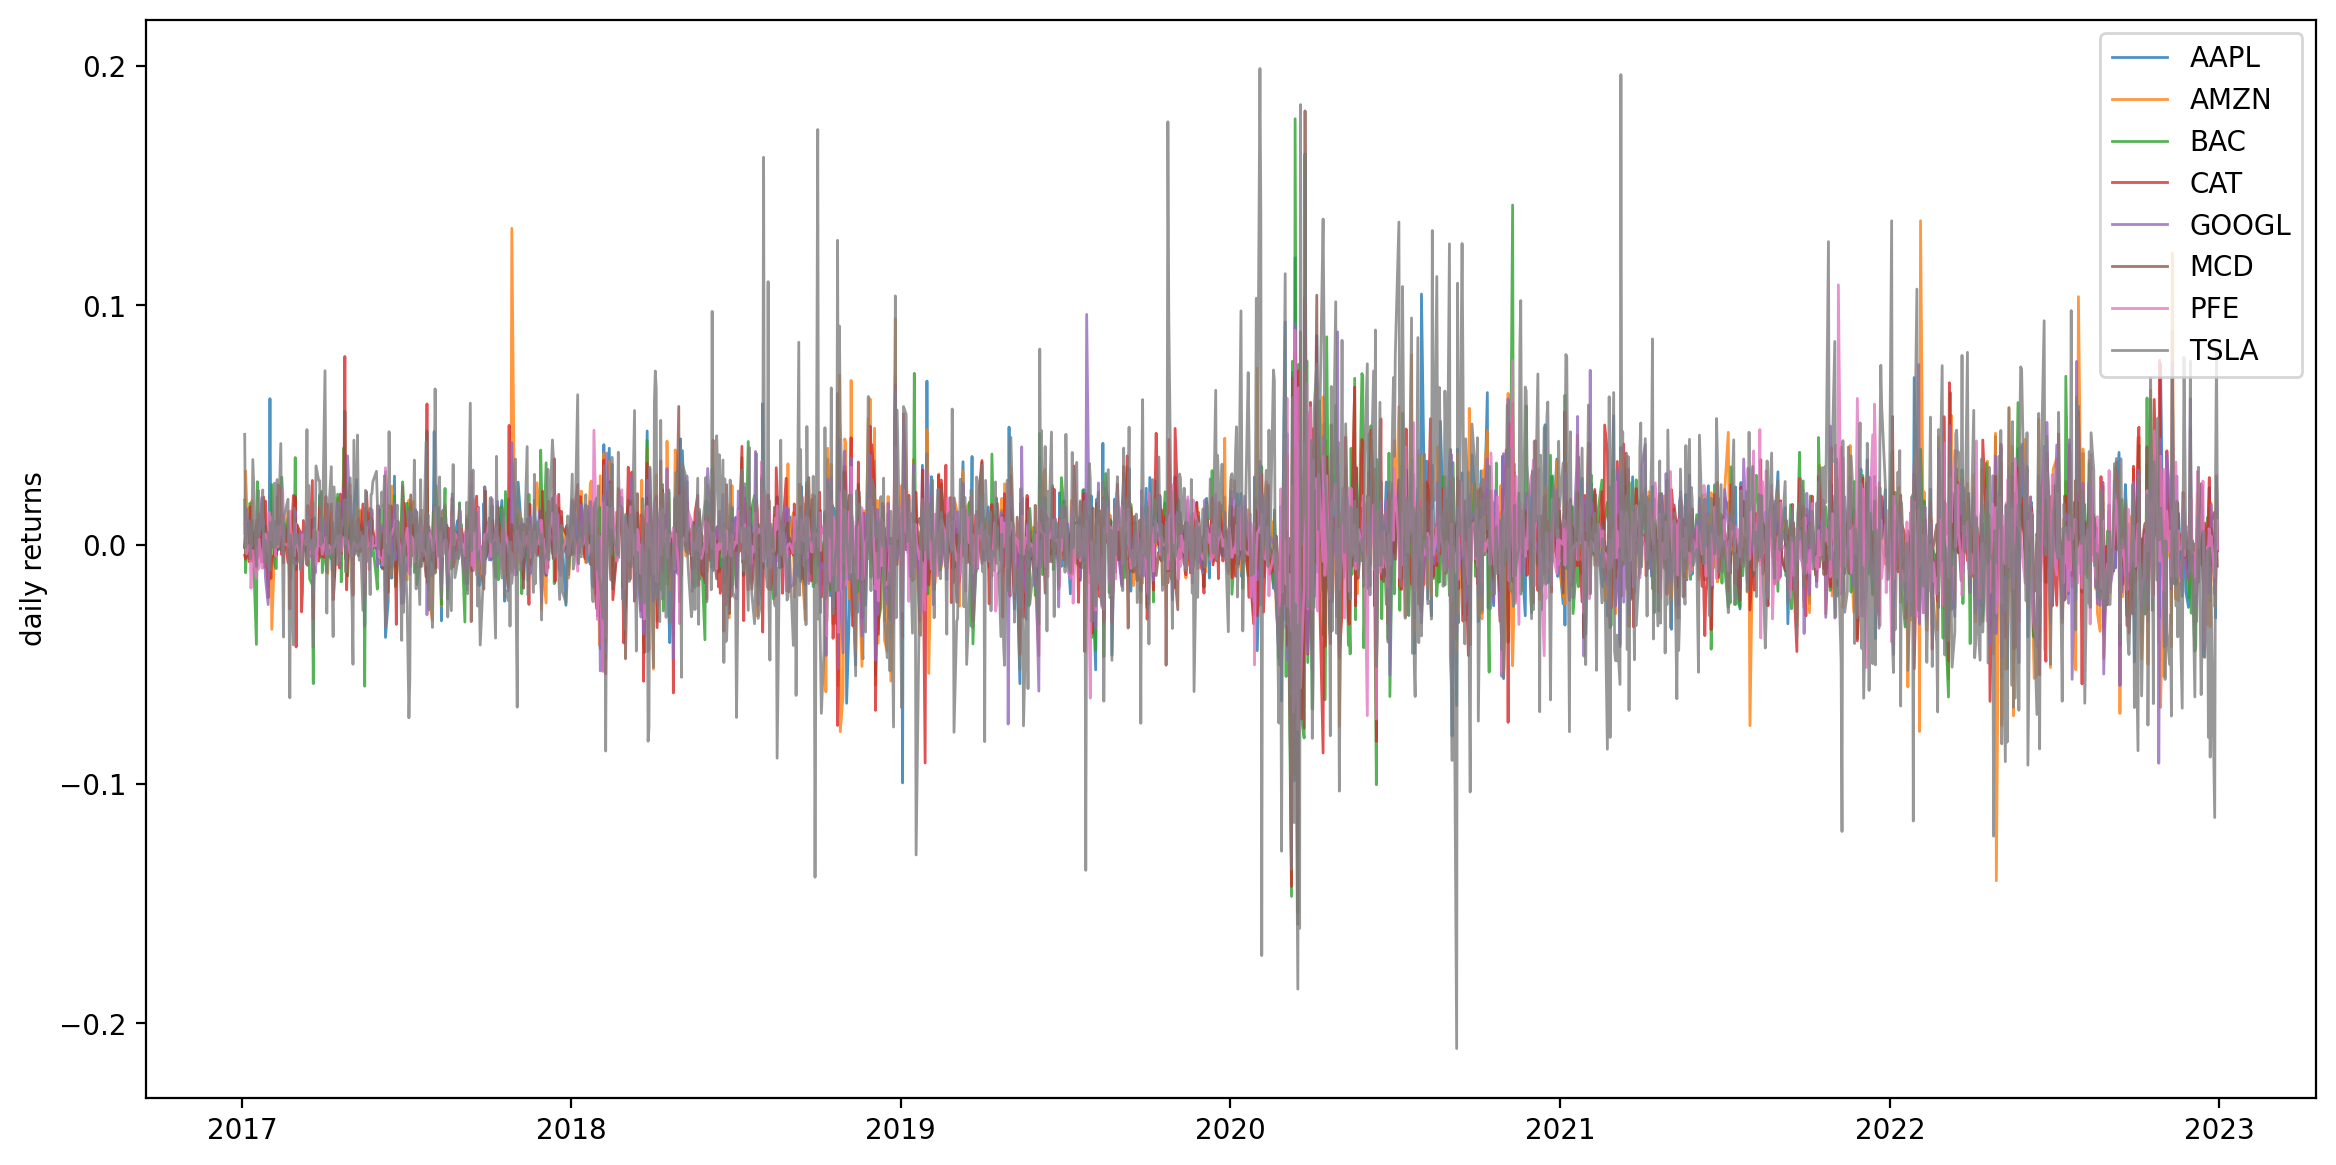

In [105]:

# Calculate the daily percentage returns of the table and then plot the daily returns for each column
# Need daily returns for corelation analysis
returns = table.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=1, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=10)
plt.ylabel('daily returns')

In [106]:

#Estimate the inputs needed for the MV Analysis
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 2500 # number of random portfolios


a. One factor model (use S&P 500 to represent the market)

In [107]:


#defining the list of companies
stocks = ["AAPL","AMZN","GOOGL","BAC","MCD","CAT","TSLA","PFE"]

#Loading the historical monthly data for the S&P 500 index

sp500 = yf.download("^GSPC", start = "2017-01-01", end ="2021-12-31", interval = "1mo")
sp500_returns = sp500["Adj Close"].pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


In [108]:
#Loading the historical monthly data for each company

company_data = {}
for stock in stocks:
    company = yf.download(stock, start='2017-01-01', end='2021-12-31', interval='1mo')
    if len(company) > 0:
        company_data[stock] = company['Adj Close'].pct_change().dropna()
        print(f"Downloaded data for {stock}")
    else:
        print(f"Data not available for {stock}")

[*********************100%***********************]  1 of 1 completed
Downloaded data for AAPL
[*********************100%***********************]  1 of 1 completed
Downloaded data for AMZN
[*********************100%***********************]  1 of 1 completed
Downloaded data for GOOGL
[*********************100%***********************]  1 of 1 completed
Downloaded data for BAC
[*********************100%***********************]  1 of 1 completed
Downloaded data for MCD
[*********************100%***********************]  1 of 1 completed
Downloaded data for CAT
[*********************100%***********************]  1 of 1 completed
Downloaded data for TSLA
[*********************100%***********************]  1 of 1 completed
Downloaded data for PFE


In [109]:
#Performing Linear Regression for the S&P500 returnns

sp500_model_data = pd.DataFrame({"S&P 500 Returns": sp500_returns})

sp500_model_data["Constant"] = 1 #adding a constant term for intercept

sp500_model = sm.OLS(sp500_model_data["S&P 500 Returns"], sp500_model_data["Constant"])

sp500_result = sp500_model.fit()

#Printing the regression results for S&p%00

print("Regression Result for S&P 500")

print(sp500_result.summary())

print("---------------------\n")

# Perform linear regression for each company using the S&P 500 returns as the market factor
for stock in stocks:
    if stock in company_data:
        model_data = pd.concat([company_data[stock], sp500_returns], axis=1).dropna()
        model_data.columns = ['Company Returns', 'Market Returns']
        model = sm.OLS(model_data['Company Returns'], sm.add_constant(model_data['Market Returns']))
        result = model.fit()

        # Print the regression results for each company
        print(f"Regression Results for {stock}")
        print(result.summary())
        print("-----------------------------------------------------------\n")



Regression Result for S&P 500
                            OLS Regression Results                            
Dep. Variable:        S&P 500 Returns   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 07 Jun 2023   Prob (F-statistic):                nan
Time:                        22:41:45   Log-Likelihood:                 100.01
No. Observations:                  59   AIC:                            -198.0
Df Residuals:                      58   BIC:                            -195.9
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant       0.0136 

b. Fama-French 3 factor models

In [110]:
# Define the list of companies
stocks = ['AAPL', 'AMZN', 'GOOGL', 'BAC', 'MCD', 'CAT', 'TSLA', 'PFE']

# Load the historical monthly data for the factors (SMB, HML)
print("Downloading factor data (SMB, HML)...")
factors = yf.download(['SMB', 'HML'], start='2017-01-01', end='2021-12-31', interval='1mo')
factors = factors['Adj Close'].pct_change().dropna()
print("Factor data downloaded successfully.")

# Load the historical monthly data for each company
company_data = {}
for stock in stocks:
    print(f"Downloading data for {stock}...")
    company_data[stock] = yf.download(stock, start='2017-01-01', end='2021-12-31', interval='1mo')
    company_data[stock]['Returns'] = company_data[stock]['Adj Close'].pct_change().dropna()
    print(f"Data downloaded successfully for {stock}.")

[*********************100%***********************]  2 of 2 completed
Factor data downloaded successfully.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for AAPL.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for AMZN.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for GOOGL.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for BAC.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for MCD.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for CAT.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for TSLA.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for PFE.


In [111]:
#Let's perform the Fama-French three factor regression for each company


results = {}
for stock in stocks:
    merged_data = pd.concat([company_data[stock]['Returns'], factors], axis=1).dropna()
    merged_data.columns = ['Returns', 'SMB', 'HML']
    model = sm.OLS(merged_data['Returns'], sm.add_constant(merged_data[['SMB', 'HML']]))
    result = model.fit()
    results[stock] = result

# Print the regression results for each company
for stock in stocks:
    print(f"Company: {stock}")
    print(results[stock].summary())
    print("-----------------------------------------------------------\n")

Company: AAPL
                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     2.652
Date:                Wed, 07 Jun 2023   Prob (F-statistic):             0.0794
Time:                        22:41:47   Log-Likelihood:                 64.635
No. Observations:                  59   AIC:                            -123.3
Df Residuals:                      56   BIC:                            -117.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0288      0.011      

c. Use the resulting models to calculate the predicted monthly returns for each month in 2022. You can use the actual factor values in 2022 (S&P 500 index, and the F-F factor values).

In [118]:
stocks = ['AAPL', 'AMZN', 'GOOGL', 'BAC', 'MCD', 'CAT', 'TSLA', 'PFE']
factors = ['^GSPC', 'SMB']  # S&P 500, SMB

In [119]:
# Retrieve factor data
print("Downloading factor data...")
factor_data = yf.download(factors, start='2022-01-01', end='2022-12-31', interval='1mo')
factor_data = factor_data['Adj Close'].pct_change().dropna()
print("Factor data downloaded successfully.")

# Retrieve company data
company_data = {}
for stock in stocks:
    print(f"Downloading data for {stock}...")
    company_data[stock] = yf.download(stock, start='2017-01-01', end='2021-12-31', interval='1mo')
    company_data[stock]['Returns'] = company_data[stock]['Adj Close'].pct_change().dropna()
    print(f"Data downloaded successfully for {stock}.")



[*********************100%***********************]  2 of 2 completed
Factor data downloaded successfully.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for AAPL.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for AMZN.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for GOOGL.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for BAC.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for MCD.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for CAT.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for TSLA.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for PFE.


In [120]:
#Defining list of companies

stocks = ["AAPL","AMZN","GOOGL","BAC","MCD","CAT","TSLA","PFE"]

#Create an empty dataframe to store the predicted returns

predictions = pd.DataFrame(index = pd.date_range(start ="2022-01-01", end= "2022-12-31", freq ="M"), columns =stocks)


In [121]:
results = {}

# Iterate over each company and use the corresponding regression model to predict returns
for stock in stocks:
    if stock in results:
        regression_model = results[stock]  # Retrieve the regression model for the company
        company_data_stock = company_data[stock]  # Retrieve the historical data for the company

        # Prepare the data for prediction
        factor_values = company_data_stock[['SMB', 'HML']]  # Use the actual factor values from the historical data
        factor_values = sm.add_constant(factor_values)

        # Predict the returns for each month in 2022 using the regression model
        predicted_returns = regression_model.predict(factor_values)

        # Store the predicted returns in the DataFrame
        predictions[stock] = predicted_returns

# Print the predicted returns for each month in 2022
print(predictions)

           AAPL AMZN GOOGL  BAC  MCD  CAT TSLA  PFE
2022-01-31  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN
2022-02-28  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN
2022-03-31  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN
2022-04-30  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN
2022-05-31  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN
2022-06-30  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN
2022-07-31  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN
2022-08-31  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN
2022-09-30  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN
2022-10-31  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN
2022-11-30  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN
2022-12-31  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN


In [126]:
# Define the list of companies
companies = ['AAPL', 'AMZN', 'GOOGL', 'BAC', 'MCD', 'CAT', 'TSLA', 'PFE']

# Load the historical monthly data for the factors (S&P 500, SMB)
factor_data = yf.download(['^GSPC', 'SMB'], start='2022-01-01', end='2022-12-31', interval='1mo')
factor_data = factor_data['Adj Close'].pct_change().dropna()

# Load the historical monthly data for each company
company_data = {}
for company in companies:
    company_data[company] = yf.download(company, start='2017-01-01', end='2022-12-31', interval='1mo')
    company_data[company]['Returns'] = company_data[company]['Adj Close'].pct_change().dropna()

# Perform the regression models again using the updated data
results = {}
for company in companies:
    merged_data = pd.concat([company_data[company]['Returns'], factor_data], axis=1).dropna()
    merged_data.columns = ['Company Returns', '^GSPC', 'SMB']
    model = sm.OLS(merged_data['Company Returns'], sm.add_constant(merged_data[['^GSPC', 'SMB']]))
    result = model.fit()
    results[company] = result

# Calculate the predicted monthly returns for each company in 2022
predictions = pd.DataFrame(index=factor_data.index, columns=companies)
for company in companies:
    factor_values = factor_data.dropna()
    predictions[company] = results[company].predict(sm.add_constant(factor_values[['^GSPC', 'SMB']]))

# Print the predicted monthly returns for each company in 2022
print(predictions)


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                AAPL      AMZN     GOOGL       BAC       MCD       CAT  \
Date                                                                     
2022-02-01  0.061645 -0.017979 -0.061638 -0.017363  0.039750  0.120508   
2022-03-01 -0.122968 -0.069354  0.005183 -0.021600 -0.034380 -0.085083   
2022-04-01  0.174340 -0.014248 -0.144920 -0.055002  0.077245  0.234630   
2022-05-0

In [127]:
factor_data


,SMB,^GSPC
Date,,
2022-02-01,-0.001713,-0.031360
2022-03-01,-0.020888,0.035773
2022-04-01,-0.015633,-0.087957
2022-05-01,0.017708,0.000053
2022-06-01,0.000426,-0.083920
2022-07-01,0.005092,0.091116
2022-08-01,-0.014572,-0.042440
2022-09-01,-0.014771,-0.093396
2022-10-01,-0.006098,0.079863


d. Compate them with the actual average monthyl returns for the stocks.

In [128]:
# Step 1: Calculate actual average monthly returns for each stock in 2022
actual_returns_2022 = pd.DataFrame(index=stocks, columns=['Actual Returns'])

for stock in stocks:
    if stock in company_data and 'Returns' in company_data[stock]:
        actual_returns_2022.loc[stock, 'Actual Returns'] = company_data[stock]['Returns']['2022'].mean()

# Step 2: Retrieve predicted monthly returns from the 'predictions' DataFrame
predicted_returns_2022 = predictions.mean()

# Step 3: Compare actual and predicted returns
comparison = pd.concat([actual_returns_2022, predicted_returns_2022], axis=1)
comparison.columns = ['Actual Returns', 'Predicted Returns']

# Print the comparison of actual and predicted returns
print(comparison)


      Actual Returns  Predicted Returns
AAPL       -0.021235           0.016579
AMZN       -0.048421          -0.026143
GOOGL       -0.03756          -0.038595
BAC        -0.017222          -0.012024
MCD         0.002477           0.022883
CAT         0.022394           0.072124
TSLA       -0.068295           0.021575
PFE        -0.006416          -0.004148
